In [2]:
import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from TALNetModel import *
from util_in_multi_h5_unnorm_AST import *
from util_out import *
from util_f1 import *
# from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

7793654


In [4]:
torch.cuda.is_available()
torch.cuda.device_count()

8

# VICTIM MODEL

In [5]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default='bal', help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')

parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 2)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = bool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'att', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--addpos', type = bool, default = True)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### TALtrans 64x400 best model

In [22]:
args = parser.parse_args(args=['--model_type=TAL','--dataset=audioset_s','--n_mels=64', '--mean=-29.072655','--std=40.71728',
                               '--lr=1.6e-3','--batch-size=400','--n-epochs=10',
                               '--freqm=12','--timem=75','--mixup=0.3',
                               '--transformer_dropout=0.25','--addpos=True','--pooling=att',
                               '--embedding_size=1024',
                               '--imagenet_pretrain=True','--suffix=big_feat_embed1024-40.6'])
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
args.target_length=400
exp_id = f"{args.model_type}-{args.dataset}-{args.dataset_portion}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}\
-conv{args.n_conv_layers}-pool{args.n_pool_layers}-trans{args.n_trans_layers}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.10.pth')

TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024-40.6


### AST 128x1024 best model

In [23]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024-40.6/models/audio_model.10.pth


In [24]:
args

Namespace(addpos=True, audioset_pretrain=True, bal='bal', batch_norm=True, batch_size=400, continue_from_ckpt=None, dataset='audioset_s', dataset_portion='full', dropout=0.0, embedding_size=1024, exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, kernel_size=(3, 3), lr='1.6e-3', lr_patience=2, mean=-29.072655, mixup=0.3, model_type='TAL', n_conv_layers=10, n_epochs=10, n_mels=64, n_pool_layers=5, n_print_steps=100, n_trans_layers=2, num_workers=32, optim='adam', pooling='att', std=40.71728, suffix='big_feat_embed1024-40.6', target_length=400, timem=75, transformer_dropout=0.25, tstride=8)

In [25]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = TALNet(args)
elif args.model_type == 'TALtrans':
    model = TransformerEncoder(args)
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


In [26]:
optimizer = Adam(model.parameters())

In [27]:
prev_ckpt = torch.load(MODEL_FILE)
# print(prev_ckpt.keys())
# start_ckpt = prev_ckpt['epoch']
# # scheduler.load_state_dict(prev_ckpt['scheduler'])
# temp = {}
# for key, val in prev_ckpt.items():
#     key = key.replace('module.','')
#     temp[key] = val
model = nn.DataParallel(model)
# # print(model.keys)
model.load_state_dict(prev_ckpt)

# # optimizer.load_state_dict(prev_ckpt['optimizer'])
# # write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()
model.cuda()

DataParallel(
  (module): TALNet(
    (conv): ModuleList(
      (0): ConvBlock(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): 

In [28]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [29]:
gas_eval_x1.shape, gas_eval_y.shape

((20123, 400, 64), (20123, 527))

# Inference

In [30]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [31]:
print(result[0].shape)

(20123, 527)


In [32]:
gas_eval_global_prob_multi = result[0]
print(gas_eval_global_prob_multi.shape)

(20123, 527)


In [33]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [34]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.4059267873096632 0.9715889065553787 2.6936187802698615
 Average | 0.406 | 0.972 | 2.694 
---------+-------+-------+-------
       0 | 0.786 | 0.933 | 2.114 
       1 | 0.058 | 0.835 | 1.377 
       2 | 0.091 | 0.945 | 2.259 
       3 | 0.393 | 0.970 | 2.656 
       4 | 0.206 | 0.977 | 2.818 
       5 | 0.064 | 0.945 | 2.256 
       6 | 0.547 | 0.997 | 3.846 
       7 | 0.438 | 0.982 | 2.970 
       8 | 0.171 | 0.952 | 2.348 
       9 | 0.158 | 0.947 | 2.282 
      10 | 0.225 | 0.971 | 2.674 
      11 | 0.218 | 0.978 | 2.846 
      12 | 0.845 | 0.999 | 4.597 
      13 | 0.521 | 0.996 | 3.730 
      14 | 0.217 | 0.979 | 2.875 
      15 | 0.779 | 0.999 | 4.376 
      16 | 0.431 | 0.983 | 3.014 
      17 | 0.628 | 0.996 | 3.735 
      18 | 0.232 | 0.983 | 3.013 
      19 | 0.246 | 0.983 | 2.992 
      20 | 0.373 | 0.990 | 3.315 
      21 | 0.226 | 0.980 | 2.903 
      22 | 0.497 | 0.987 | 3.169 
      23 | 0.497 | 0.993 | 3.494 
      24 | 0.246 | 0.968 | 2.628 
      25 | 0.119 | 0.929 

# Occlusion

In [105]:
gas_eval_x1_origin = gas_eval_x1

In [106]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.2922494 1.4197426 -0.158013 0.62080556


In [107]:
gas_eval_x1.shape

(20123, 400, 64)

In [84]:
# new_gas_eval = []
# time_frame = 1024#400
# step = 16#40
# half = 512#200
# n_mel = 128#64

# for record in gas_eval_x1[:,:1020,:]:
#     record=numpy.ma.array(record,mask=False)
#     silence_val = numpy.min(record)
#     count = 0
#     for i in range(time_frame):
#         if i % step == 0:
#             count +=1
#         if count % 2 == 0:
#             record.mask[i] = True
#     mask_record = record.compressed().reshape(half,n_mel)
#     fill_matrix = numpy.full((half,n_mel), silence_val)
# #     print('shape', fill_matrix.shape)
#     mask_record = numpy.vstack((mask_record, fill_matrix))
# #     record.mask[100:300]=True
# #     mask_record = record[~record.mask]
# #     print(mask_record.shape)
# #     mask_record = record.filled(fill_value=silence_val)
#     new_gas_eval.append(mask_record)
# new_gas_eval = numpy.array(new_gas_eval)

IndexError: index 1020 is out of bounds for axis 0 with size 1020

In [26]:
# new_gas_eval.shape

In [85]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

IndexError: list index out of range

<Figure size 1440x720 with 0 Axes>

In [86]:
new_gas_eval = []
time_frame = 1024#400
step = 16#40
half = 512#200
n_mel = 128#64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [29]:

# plt.figure(figsize = (20,10))
# plt.imshow(new_gas_eval[2].T, origin='lower')

In [30]:
# new_gas_eval = []

# for record in gas_eval_x1:
#     record=numpy.ma.array(record,mask=False)
#     silence_val = numpy.min(record)
#     record.mask[255:765]=True
#     mask_record = record.filled(fill_value=silence_val)
#     new_gas_eval.append(mask_record)
# new_gas_eval = numpy.array(new_gas_eval)

In [31]:

# plt.figure(figsize = (20,10))
# plt.imshow(new_gas_eval[2].T, origin='lower')

In [32]:
# import numpy as np
# new_gas_eval = []
# for record in gas_eval_x1:
#     record += np.random.normal(0, 0.1, (1024,128))
#     new_gas_eval.append(record)
# new_gas_eval = numpy.array(new_gas_eval)

In [33]:

# plt.figure(figsize = (20,10))
# plt.imshow(new_gas_eval[2].T, origin='lower')

In [112]:
from torch.cuda.amp import autocast,GradScaler

In [113]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.2922494 1.4197426


In [114]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=100, shuffle=True)

In [115]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCEWithLogitsLoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check
            with autocast():
                out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

                loss = criterion(out, y.to('cuda', non_blocking=True))
                loss_global += loss.item()
#                 print(loss.item(), loss_global)
                loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [ ]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.03, step_norm='inf', eps= 0.5, eps_norm='2', x_min=-2.29, x_max=1.42, y_target=None )


global loss:2.654737657867372
global loss:2.892211507074535
global loss:3.645229876972735


In [118]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

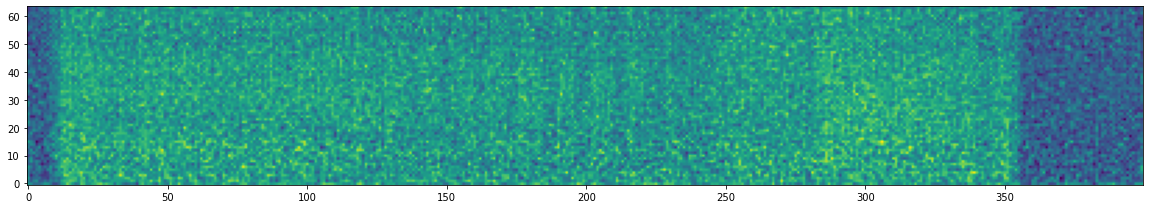

In [119]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[2].T, origin='lower')

In [46]:
import matplotlib.pyplot as plt


In [41]:
plt.plot(classwise)
plt.figure(figsize=(400,100)) 


NameError: name 'classwise' is not defined

# Adversarial Routine

In [ ]:
for batch in range(1, args.ckpt_size + 1):
        x, y = next(train_gen)
        global_prob = model(x)[0]
        global_prob.clamp_(min = 1e-7, max = 1 - 1e-7)
        loss = criterion(global_prob, y)
        if args.gradient_accumulation > 1:
            loss = loss / args.gradient_accumulation
        #if n_gpu > 1:
        #    loss = loss.mean()
        train_loss += loss.item()
        if numpy.isnan(train_loss) or numpy.isinf(train_loss): break
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation == 0:
            optimizer.step()
            if args.scheduler == 'warmup-decay':
                scheduler.step() 
            optimizer.zero_grad()
        if batch % 500 == 0:
            sys.stderr.write('Checkpoint %d, Batch %d / %d, avg train loss = %f\r' % \
                            (checkpoint, batch, args.ckpt_size, train_loss / batch))
            tb_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step)
            tb_writer.add_scalar('loss', train_loss / batch, global_step)
            
        del x, y, global_prob, loss         # This line and next line: to save GPU memory
        torch.cuda.empty_cache()            # I don't know if they're useful or not
    train_loss /= args.ckpt_size


In [ ]:
def train(opt, model, adv_jam, trainloader, max_batches = 100):
    model.eval()
        
    batches = 0
    total = 0
    error = 0
    loss_ = 0.
    torch.manual_seed(0)

    for X_batch, y_batch in trainloader:
        # forward pass
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        # plot(X_batch[0], y_batch[0])
        output = model(adv_jam(X))
        opt.zero_grad()
        neg_loss = -nn.CrossEntropyLoss()(output, y)

        neg_loss.backward()
        opt.step()



        # Evaluate performance
        adv_out = model(X_adv)
        adv_prediction = sigmoid(adv_out.squeeze().cpu().detach())>0.5
        adv_accuracy = (adv_prediction.numpy()==y_batch.cpu().numpy()).mean()
        print("Accuracy = {0}".format(adv_accuracy))
                # project into feasible region
        adv.jam.param1.clamp_(0,1)
        adv.jam.param2.clamp_(1, 40)
        adv.jam.param3.clamp_(0,224)
        total += X.shape[0]
        error += (output.max(1)[1] != y).sum().item()
        loss_ += nn.CrossEntropyLoss(size_average=False)(output, y).item()
            batches += 1
            if batches > max_batches:
                break

        return error / total, loss_ / total

In [ ]:
def projected_gradient_descent(model, x, y, num_steps = 20, step_size = 0.1, step_norm=2, eps = 10, eps_norm=2,
                               clamp=(x_min, x_max), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        
        out = model(_x_adv) # N x T x 1
        out_flatten = out.reshape(-1) 
        y_flatten = y.reshape(-1)
        loss = criterion(out_flatten, y_flatten)
        
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
                
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            scaling_factor[mask] = eps
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()